In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Preparación de los datos

In [101]:
# Especificar los tipos de datos para las columnas problemáticas
dtype_dict = {
    'gpu_spec': 'string', 
    'qos': 'string',
    'pod_phase': 'string'
}

extracted_data = pd.read_csv('data/concatenated_openb_pod_list.csv', dtype=dtype_dict)
extracted_data.head()

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time,source_file
0,openb-pod-0000,12000,16384,1,1000,<NA>,LS,Running,0.0,12537496.0,0.0,openb_pod_list_cpu0.csv
1,openb-pod-0001,6000,12288,1,460,<NA>,LS,Running,427061.0,12902960.0,427061.0,openb_pod_list_cpu0.csv
2,openb-pod-0002,12000,24576,1,1000,<NA>,LS,Running,1558381.0,12902960.0,1558381.0,openb_pod_list_cpu0.csv
3,openb-pod-0003,6000,12288,1,460,<NA>,LS,Running,2690044.0,12902960.0,2690044.0,openb_pod_list_cpu0.csv
4,openb-pod-0004,12000,16384,1,1000,<NA>,LS,Running,2758084.0,12902960.0,2758084.0,openb_pod_list_cpu0.csv


In [102]:
extracted_data.describe()

,cpu_milli,memory_mib,num_gpu,gpu_milli,creation_time,deletion_time,scheduled_time
count,158437.000000,158437.000000,158437.000000,158437.000000,1.237980e+05,1.237980e+05,1.102910e+05
mean,11129.810133,39956.433510,0.964768,698.506031,1.154434e+07,1.157001e+07,1.151961e+07
std,10382.929389,43571.796757,0.887899,369.487685,9.528673e+05,8.892330e+05,9.588049e+05
min,1000.000000,0.000000,0.000000,0.000000,0.000000e+00,9.964972e+06,0.000000e+00
25%,4000.000000,15360.000000,1.000000,470.000000,1.073528e+07,1.075549e+07,1.071781e+07
50%,11300.000000,41560.000000,1.000000,810.000000,1.151461e+07,1.153480e+07,1.148895e+07
75%,12000.000000,49152.000000,1.000000,1000.000000,1.240467e+07,1.242423e+07,1.237422e+07
max,120200.000000,737280.000000,8.000000,1000.000000,1.290176e+07,1.290296e+07,1.290176e+07


In [103]:
extracted_data.describe(include=['string','object'])

,name,gpu_spec,qos,pod_phase,source_file
count,158437,6692,123798,123798,158437
unique,10094,17,4,4,19
top,openb-pod-7063,T4,LS,Running,openb_pod_list_cpu300.csv
freq,19,3474,70566,79352,10094


In [104]:
extracted_data.isnull().sum()


name                   0
cpu_milli              0
memory_mib             0
num_gpu                0
gpu_milli              0
gpu_spec          151745
qos                34639
pod_phase          34639
creation_time      34639
deletion_time      34639
scheduled_time     48146
source_file            0
dtype: int64

In [105]:
filtered_data = extracted_data[(extracted_data['pod_phase'].notna()) & (extracted_data['scheduled_time'] > 0)]
filtered_data = filtered_data.rename(columns={'num_gpu': 'workers'})

In [106]:
# Mantener la primera versión de un registro duplicado en un nuevo dataframe
no_dups_df = filtered_data.drop_duplicates(keep='first', inplace=False)

# Contar duplicados
dups_rows = filtered_data[filtered_data.duplicated(keep='first')]

# Calcular el porcentaje de duplicados
porcentaje_dups = (dups_rows.shape[0] / filtered_data.shape[0]) * 100

# Imprimir resultados:
print(f'Cantidad de Registros Originales: {filtered_data.shape[0]}')
print(f"Cantidad de Registros duplicados: {dups_rows.shape[0]}")
print(f"Porcentaje de duplicados sobre la muestra original: {porcentaje_dups:.2f}%")
print(f"Cantidad de Registros sin dups  : {no_dups_df.shape[0]}")


Cantidad de Registros Originales: 110276
Cantidad de Registros duplicados: 0
Porcentaje de duplicados sobre la muestra original: 0.00%
Cantidad de Registros sin dups  : 110276


In [107]:
data = filtered_data.copy()

# Reemplazar valores <NA> con '0' en columnas de tipo string
for col in data.select_dtypes(include=['string']).columns:
    data[col] = data[col].fillna('0')

# Reemplazar valores <NA> con 0 en columnas numéricas
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].fillna(0)

data.fillna(0, inplace=True)  


In [108]:
#Agregar nuevas columnas
data['cores'] = data['cpu_milli'] / 1000 # 1 core de CPU = 1000 millicores 
data['memory_Gbs'] = data['memory_mib'] / 1024 # 1 GiB = 1024 MiB

# Convertir 'time' de Unix timestamp a formato de fecha
data['date'] = pd.to_datetime(data['scheduled_time'], unit='ms')

# Calcular días, horas, minutos y segundos
data['days'] = (data['date'] - pd.Timestamp("1970-01-01")).dt.days   # Contar 1970-01-01 como el primer día
data['hours'] = data['date'].dt.hour
data['minutes'] = data['date'].dt.minute
data['seconds'] = data['date'].dt.second

# Ensure the datetime columns are in the correct format
data['start_time'] = pd.to_datetime(data['creation_time'])
data['end_time'] = pd.to_datetime(data['deletion_time'])

# Calculate the duration in seconds (or any other unit, e.g., minutes, hours)
data['duration'] = (data['end_time'] - data['start_time']).dt.total_seconds()

data[['cpu_milli', 'memory_mib', 'scheduled_time', 'cores', 'memory_Gbs','hours', 'minutes', 'seconds', 'duration']].describe()


,cpu_milli,memory_mib,scheduled_time,cores,memory_Gbs,hours,minutes,seconds,duration
count,110276.000000,110276.000000,1.102760e+05,110276.000000,110276.000000,110276.000000,110276.000000,110276.000000,1.102760e+05
mean,10622.457652,37046.735999,1.152118e+07,10.622458,36.178453,2.716928,28.509485,29.159464,2.709675e-05
std,8759.310746,34525.177834,9.494098e+05,8.759311,33.715994,0.458692,18.014844,17.444548,3.989832e-04
min,1000.000000,0.000000,4.270610e+05,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000e-09
25%,4000.000000,15258.000000,1.071786e+07,4.000000,14.900391,2.000000,13.000000,14.000000,2.090000e-07
50%,11300.000000,41560.000000,1.148906e+07,11.300000,40.585938,3.000000,27.000000,29.000000,6.880000e-07
75%,12000.000000,49152.000000,1.237422e+07,12.000000,48.000000,3.000000,48.000000,44.000000,2.303000e-06
max,120200.000000,737280.000000,1.290176e+07,120.200000,720.000000,3.000000,59.000000,59.000000,1.247590e-02


In [109]:
# Convertir horas a minutos, sumar minutos y segundos convertidos a minutos
data['total_time_minutes'] = data['hours'] * 60 + data['minutes'] + data['seconds'] / 60
data['total_time_hours'] = data['total_time_minutes'] / 60
# Verificar el resultado
data[['hours', 'minutes', 'seconds', 'total_time_minutes','total_time_hours']].head()

,hours,minutes,seconds,total_time_minutes,total_time_hours
1,0,7,7,7.116667,0.118611
2,0,25,58,25.966667,0.432778
3,0,44,50,44.833333,0.747222
4,0,45,58,45.966667,0.766111
5,0,50,19,50.316667,0.838611


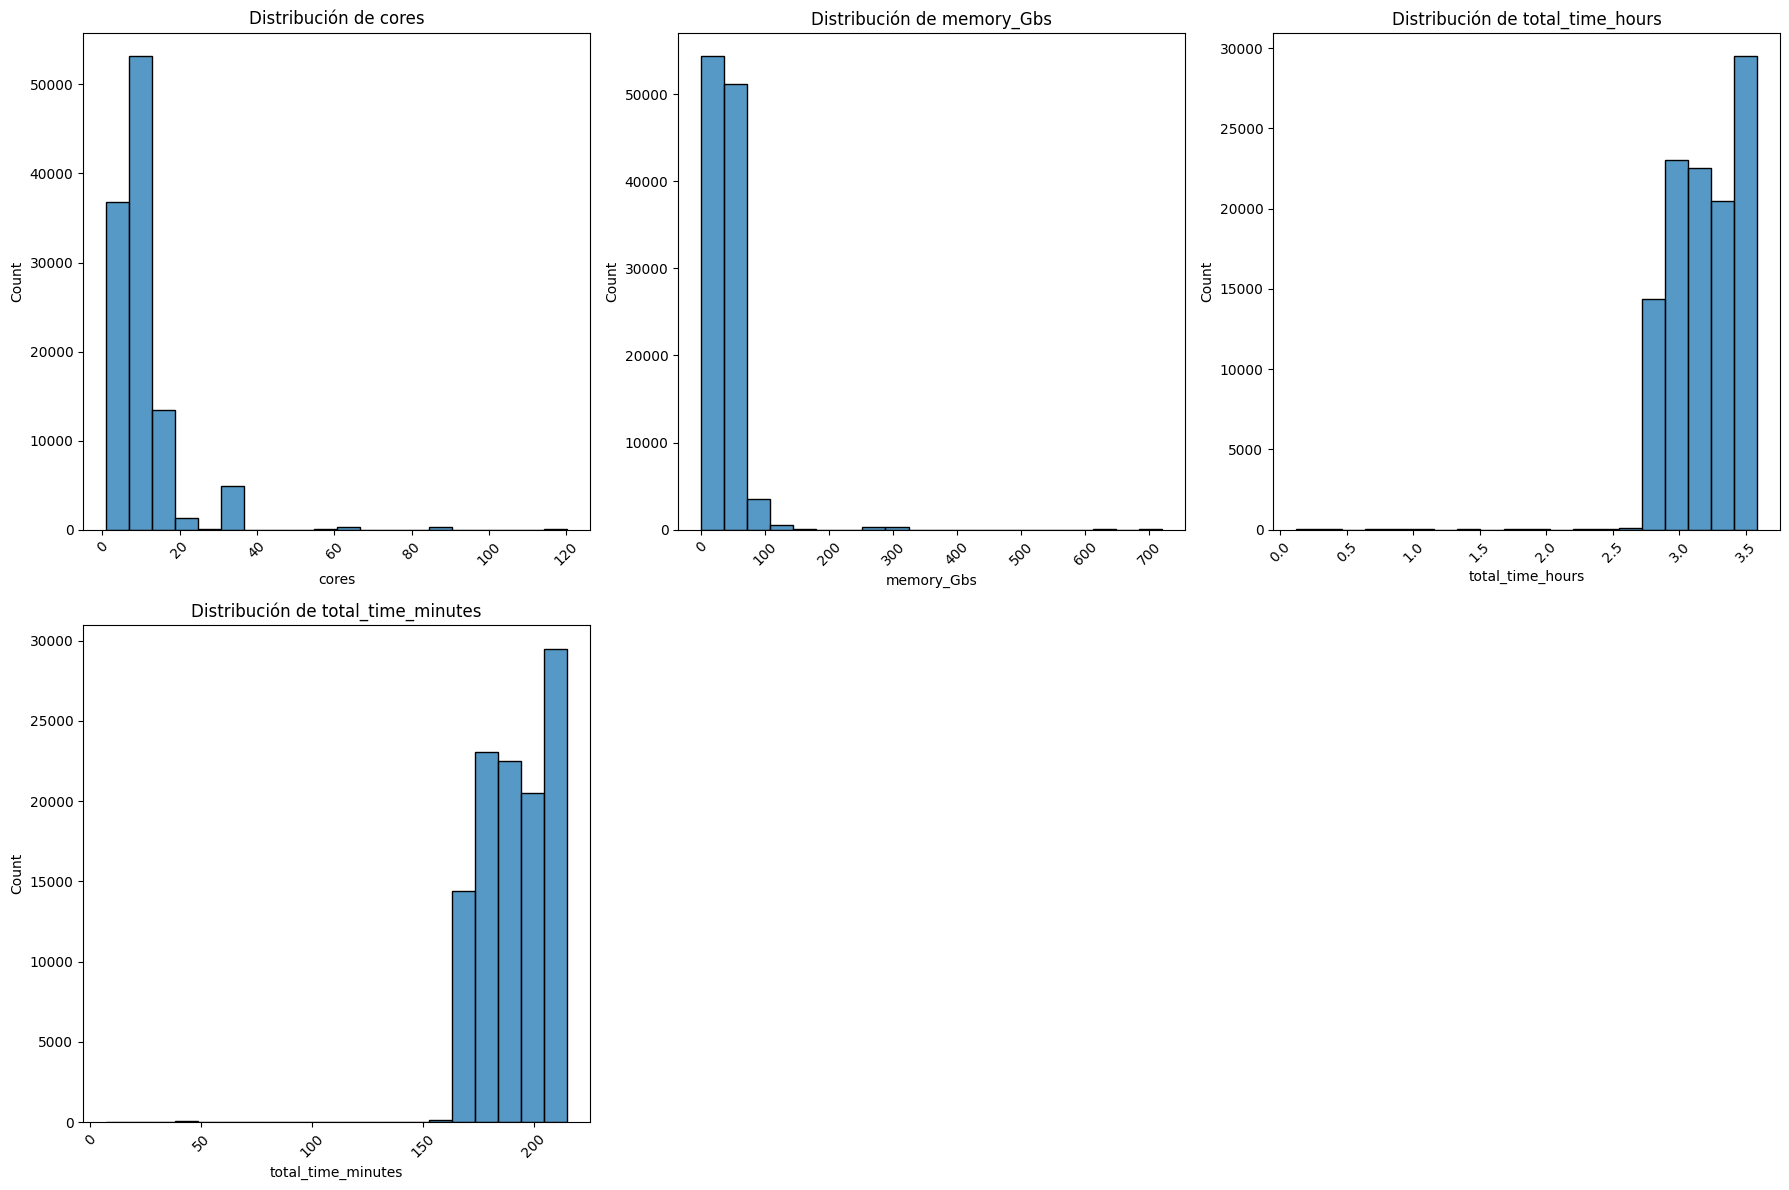

In [110]:
# Seleccionar columnas numéricas
numeric_data = data
numeric_columns = ['cores', 'memory_Gbs','total_time_hours','total_time_minutes'] #numeric_data.select_dtypes(include=['float64', 'int64']).columns

subset_df = numeric_data[numeric_columns]

# Configurar subplots para mostrar 3 gráficos por fila
num_cols = 3
num_plots = len(subset_df.columns)
num_rows = (num_plots + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))  # Ajustar tamaño
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

for i, col in enumerate(subset_df.columns):
    sns.histplot(data=subset_df, x=col, bins=20, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar gráficos vacíos si hay menos de num_rows * num_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

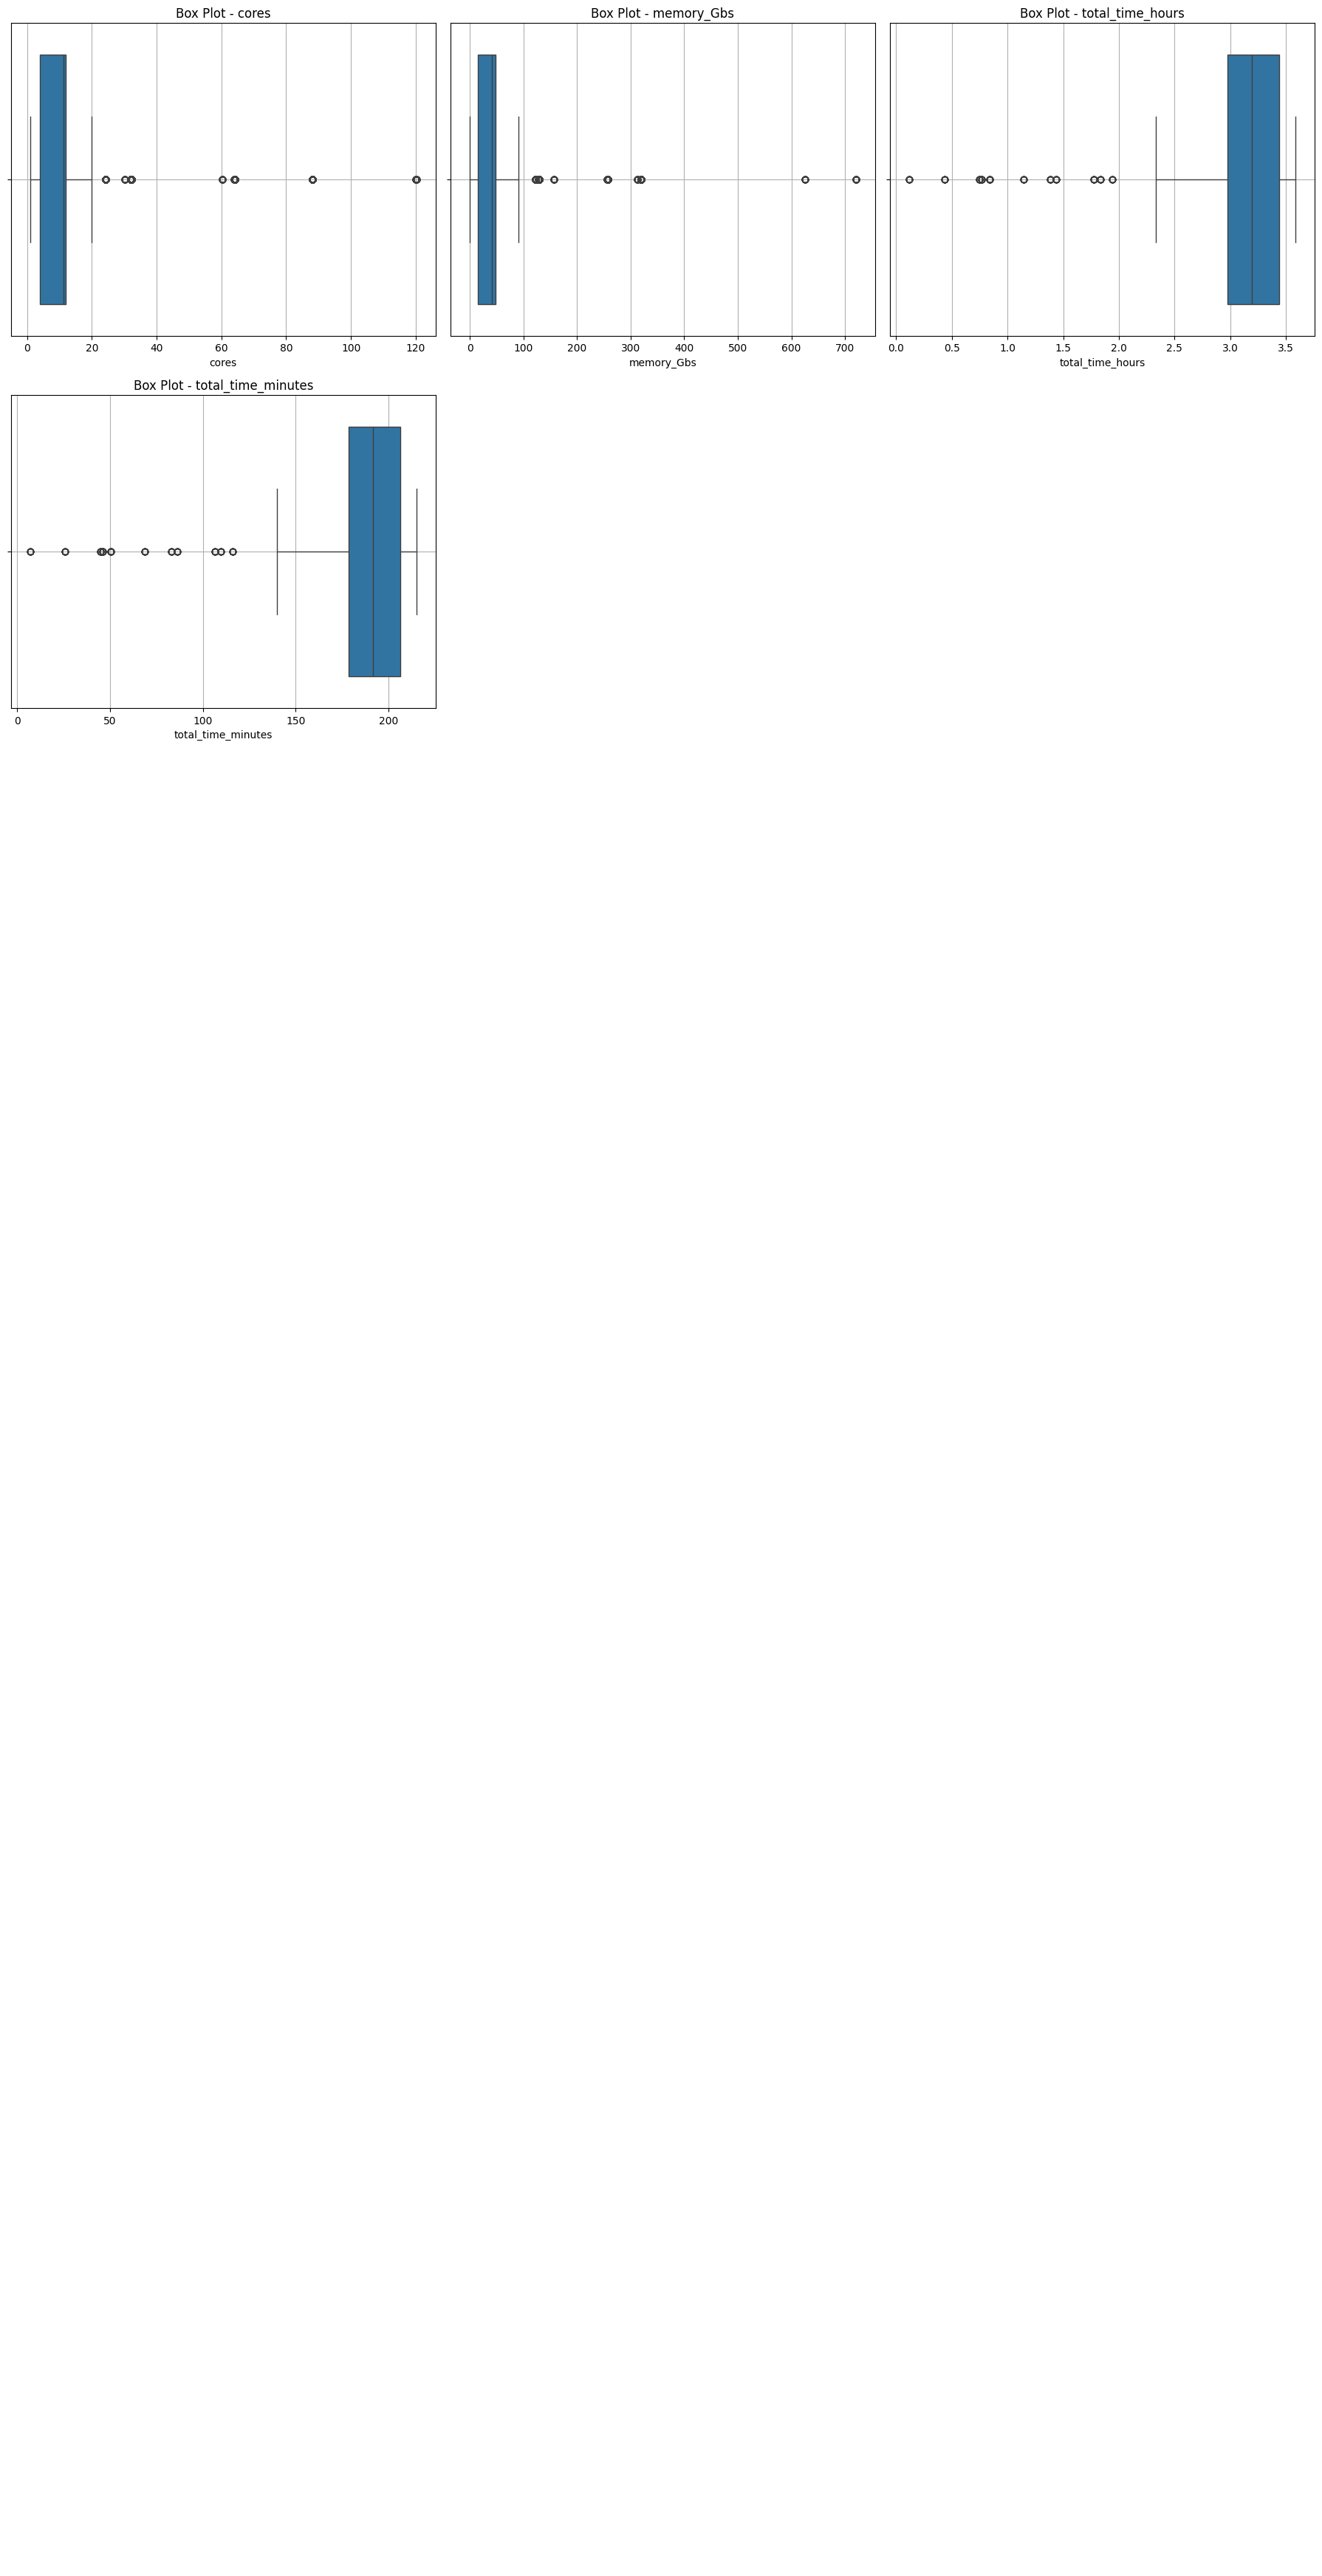

In [114]:

n_plots = len(numeric_columns)

# Calcular el número de filas necesarias
n_columns = len(numeric_data.columns)
n_rows = (n_columns + 2) // 3  # Redondeo hacia arriba

box_plot_df = numeric_data[numeric_columns]

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
axes = axes.flatten()  

# Hide unused subplots if any
for ax in axes[n_plots:]:
    ax.axis('off')

# Plot each numeric column as a boxplot
for ax, column in zip(axes, box_plot_df):
    sns.boxplot(data=box_plot_df, x=column, ax=ax)
    ax.set_title(f"Box Plot - {column}")
    ax.set_xlabel(column)
    ax.grid(True)

plt.tight_layout()  # Prevent overlapping
plt.show()

# Regresión Lineal Multiple

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Excluir columnas irrelevantes (ej: gpu_spec si es constante)
numeric_data = data.copy()

numeric_data['duracion'] = numeric_data['deletion_time'] - numeric_data['creation_time']

numeric_data = numeric_data.drop(columns=['gpu_spec','creation_time', 'deletion_time', 'scheduled_time'], errors='ignore')


# Variables predictoras (excluir gpu_spec si es constante)
X = numeric_data[['cpu_milli', 'memory_mib', 'num_gpu', 'gpu_milli']]
y = numeric_data['duracion']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar datos (usamos RobustScaler por posibles outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predecir y evaluar
y_pred = model.predict(X_test_scaled)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

KeyError: "['num_gpu'] not in index"

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predecir y evaluar
y_pred = model.predict(X_test_scaled)

# Métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

# Análisis de los coeficientes
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
})
print("\nCoeficientes del modelo:")
print(coef_df)

# Interpretación de los coeficientes
print("\nInterpretación:")
for index, row in coef_df.iterrows():
    if row['Coeficiente'] > 0:
        print(f"Un aumento en {row['Variable']} está asociado con un aumento en la duración.")
    else:
        print(f"Un aumento en {row['Variable']} está asociado con una disminución en la duración.")